In [2]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import os
from os.path import basename, splitext
from utils.utils import PatternRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 40)

In [3]:
#human GRCh37/hg19 source=(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3695075/)

p = '/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv'
dfa = pd.read_csv(p, index_col=0)
meta = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa = dfa[meta.index]
print('Age, N sites', len(dfa.index))

Age, N sites 450203


In [4]:
#corr block
#reprogramming data GRCh37/hg19 source=(https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1413299111&file=pnas.201413299SI.pdf)
dfr = pd.read_csv('./data/GSE54848/data.csv', index_col=0)
metr = pd.read_csv('data/GSE54848/GSE54848_metadata.csv', index_col=0).loc[dfr.columns]
mapper = dict(zip(metr.title.apply(lambda x: x.split('_')[0]).unique(), 
                  [0, 3, 7, 11, 15, 20 ,28, 35, 42, 49, 50, 50]))
metr['age'] = metr.title.apply(lambda x: x.split('_')[0]).map(mapper)
print('Rep, N sites', len(dfr.index))

Rep, N sites 485577


In [5]:
#common_sites
common_sites = dfa.index.intersection(dfr.index)

dfa = dfa.loc[common_sites]
dfr = dfr.loc[common_sites]

In [6]:
#get clocks
#read all clock models
paths = glob('methylclock/*.rda')
stoplist = ['coefLeeGA', 'coefTL']
clocks = {}
for p in paths:
    name = splitext(basename(p))[0]
    if name in stoplist:
        continue
    if not(name.__contains__('coef')):
        continue
    rda = pyreadr.read_r(p) # also works for Rds, rda
    clocks[name] = rda[name].set_index('CpGmarker')

In [7]:
#predict aging
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfa.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfa.columns:
        row = dfa.loc[sites, s]
        avg = row.mean()
        ## DANGER ZONE: REMOVE SAMPLE AVG 
        # repday = meta_filtered.loc[row.name]['age']
        # stage_avg = stage_averages[repday]
        # row = row - avg
        ##
        #coef_shift
        w = clock.loc[sites, 'CoefficientTraining']
        #w = w - w.mean()
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    meta['eAge' + f'_{name}'] = ages
    meta['averages'] = means
    model_predictions[name] = ages
groupa = meta.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_7732/3707657252.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupa = meta.groupby('age').mean().filter(regex='eAge')


In [8]:
#predict reprogramming
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfr.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfr.columns:
        row = dfr.loc[sites, s]
        avg = row.mean()
        ## DANGER ZONE: REMOVE SAMPLE AVG 
        # repday = meta_filtered.loc[row.name]['age']
        # stage_avg = stage_averages[repday]
        # row = row - avg
        ##
        #coef_shift
        w = clock.loc[sites, 'CoefficientTraining']
        #w = w - w.mean()
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    metr['eAge' + f'_{name}'] = ages
    metr['averages'] = means
    model_predictions[name] = ages
groupr = metr.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_7732/2508590108.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupr = metr.groupby('age').mean().filter(regex='eAge')


In [71]:
# sub = meta[['averages', 'eAge_coefHannum', 'eAge_coefHorvath', 'age']]

# g = sns.lmplot(x='averages', y='eAge_coefHorvath', data=sub)
# plt.xlabel('Reprogramming average methylation', fontsize=14)
# plt.ylabel('Horvath clocks, predicted eAge', fontsize=14)
# def annotate(data, **kws):
#     from scipy import stats
#     r, p = stats.pearsonr(data['averages'], data['eAge_coefHorvath'])
#     ax = plt.gca()
#     ax.text(.25, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
#             transform=ax.transAxes, fontsize = 14)
    
# g.map_dataframe(annotate)
# plt.show()

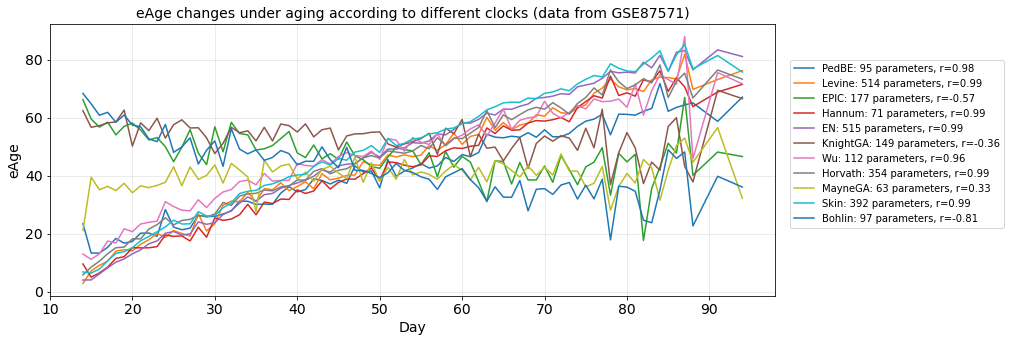

In [70]:
#Aging process
plt.figure(figsize=(13,5))
#plt.scatter(times, ages)
for name in group.columns:
    n_params = len(clocks[name.split('_')[1]].index)
    lbl = name.split('_coef')[1]
    r = np.round(np.corrcoef(group.index.tolist(), group[name])[0, 1], 2)
    plt.plot(group.index.tolist(), group[name], label=f'{lbl}: {n_params} parameters, r={r}' ) # average plot
plt.title('eAge changes under aging according to different clocks (data from GSE87571)', fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('eAge', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.grid(alpha=0.3)
plt.legend(loc=(1.02, 0.25))
plt.savefig('figs/clocks_aging.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
cname = 'coefHorvath'
clock = clocks[cname]
sites = clock.index.intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

#scaling?
# Xa_clock = Xa_clock - Xa_clock.mean(0)
# Xr_clock = Xr_clock - Xr_clock.mean(0)

In [62]:
meta['state'] = 'aging' + '_' + meta['age'].astype(str)
metr['state'] = 'rep' + '_' + metr['age'].astype(str)
met_melt = meta.append(metr)

/tmp/ipykernel_7732/3026777716.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met_melt = meta.append(metr)


In [63]:
melt = Xa_clock.sample(5).append(Xr_clock)
lbls = met_melt['state'].loc[melt.index]
melt.index = melt.index + '_' + lbls

/tmp/ipykernel_7732/1793212538.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  melt = Xa_clock.sample(5).append(Xr_clock)


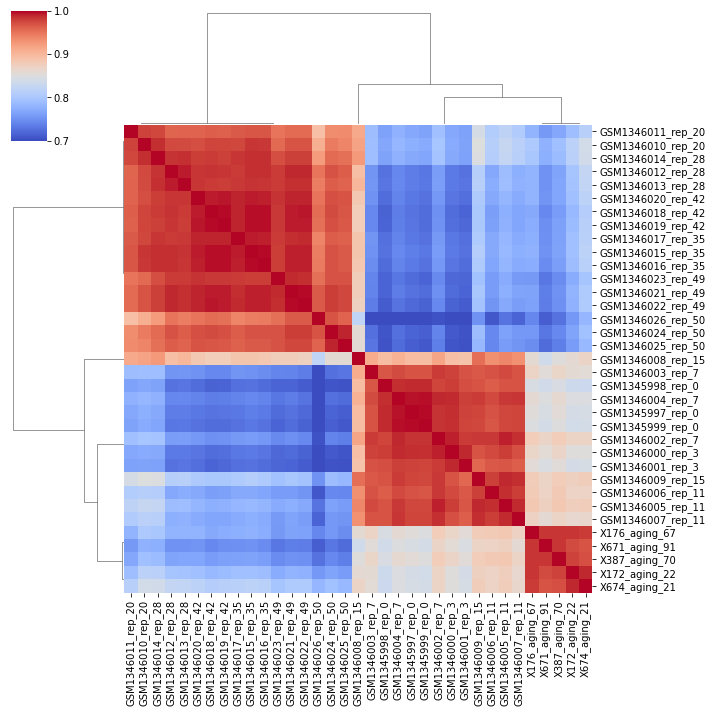

In [65]:
sns.clustermap(melt.T.corr(), metric='correlation', vmax=1, vmin=0.7, cmap='coolwarm', )

In [12]:
#do pca now

pca = PCA(3)

# Assumption: reprogramming is distributed as aging
# Xpa = pca.fit_transform(Xa_clock)
# Xpr = pca.transform(Xr_clock)

# Assumption: reprogramming is something other than aging
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

/tmp/ipykernel_7097/1674905582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


In [13]:
pvar = np.round(pca.explained_variance_ratio_, 2)

In [14]:
ya = meta[f'eAge_{cname}']
yr = metr[f'eAge_{cname}']

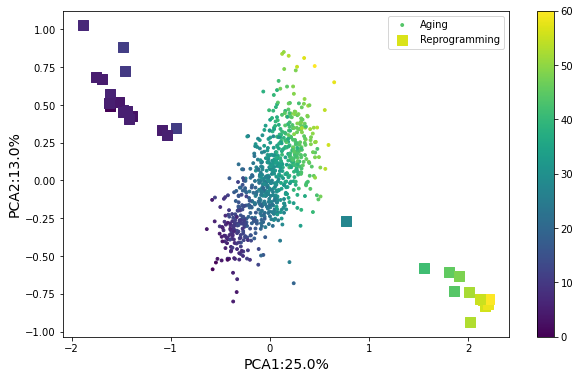

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=8, label='Aging')
plt.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=100, label='Reprogramming')
plt.xlabel(f'PCA1:{pvar[0]*100}%', fontsize=14)
plt.ylabel(f'PCA2:{pvar[1]*100}%', fontsize=14)
plt.legend()
plt.colorbar()

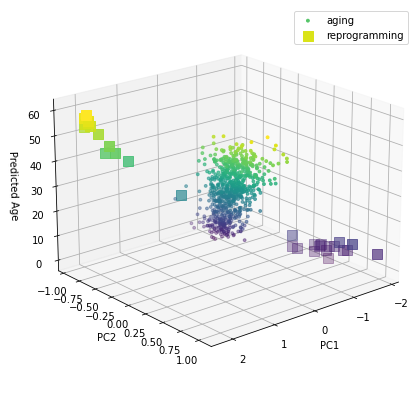

In [24]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(projection='3d')
# ax.scatter(Xpa[:, 0], Xpa[:, 1], Xpa[:, 2], c=ya, s=8)
# ax.scatter(Xpr[:, 0], Xpr[:, 1], Xpr[:, 2], c=yr, marker='s', s=100)
ax.scatter(Xpa[:, 0], Xpa[:, 1], ya, c=ya, s=8, label='aging')
ax.scatter(Xpr[:, 0], Xpr[:, 1], yr, c=yr, marker='s', s=100, label='reprogramming')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Predicted Age')
ax.view_init(20, 50)
ax.legend()